In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
df = pd.read_csv('AB_NYC_2019.csv')
df.head(3)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365


In [36]:
base = [
    'neighbourhood_group',
    'room_type',
    'latitude',
    'longitude',
    'price',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365'
]

df = df[base]

In [37]:
# fill in the missing values with 0.
df = df.fillna(0)

In [38]:
### Question 1
"""
What is the most frequent observation(mode) for the column 'neighbourhood_group'?
"""
df['neighbourhood_group'].mode()
# ANSWER to Question 1
# Manhattan

0    Manhattan
dtype: object

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [41]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)
len(df_train), len(df_val), len(df_test)

(29337, 9779, 9779)

In [42]:
y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values


In [43]:
del df_train['price']
del df_val['price']
del df_test['price']

In [44]:
df_train.dtypes

neighbourhood_group                object
room_type                          object
latitude                          float64
longitude                         float64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [45]:
numerical = list(set(list(df_train.columns)) - set(['neighbourhood_group', 'room_type']))
numerical


['reviews_per_month',
 'number_of_reviews',
 'calculated_host_listings_count',
 'latitude',
 'minimum_nights',
 'availability_365',
 'longitude']

In [46]:
### Question 2
"""
What are the two features that have the biggest correlation in this dataset?
"""
train_corr_mtx = df_train.corr()

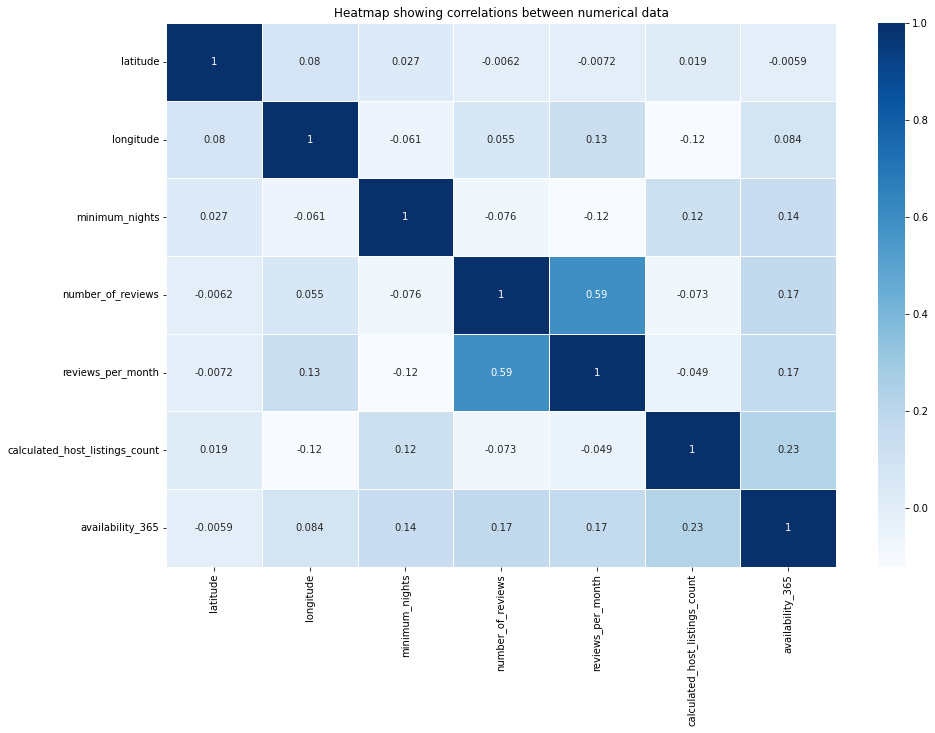

In [47]:
plt.figure(figsize=(15, 10))
sns.heatmap(train_corr_mtx, annot=True, linewidths=.5, cmap="Blues")
plt.title('Heatmap showing correlations between numerical data')
plt.show()


In [48]:
train_corr_mtx.unstack().abs().sort_values(ascending=False)
# ANSWER to Question 2
# (number_of_reviews, reviews_per_month) AND (availability_365, calculated_host_listings_count)

latitude                        latitude                          1.000000
longitude                       longitude                         1.000000
calculated_host_listings_count  calculated_host_listings_count    1.000000
reviews_per_month               reviews_per_month                 1.000000
minimum_nights                  minimum_nights                    1.000000
number_of_reviews               number_of_reviews                 1.000000
availability_365                availability_365                  1.000000
number_of_reviews               reviews_per_month                 0.590374
reviews_per_month               number_of_reviews                 0.590374
availability_365                calculated_host_listings_count    0.225913
calculated_host_listings_count  availability_365                  0.225913
availability_365                number_of_reviews                 0.174477
number_of_reviews               availability_365                  0.174477
availability_365         

In [49]:
# above_average = (y_train >= 152)

# taken from the finished homework
df_class = df.copy()
price_mean = df_class['price'].mean()
df_class['above_average'] = np.where(df_class['price'] >= price_mean,1,0)

In [50]:
df_class = df_class.drop('price', axis=1)

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
df_train_full, df_test = train_test_split(df_class, test_size=0.2, random_state=42)

In [53]:
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=42)

In [54]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [55]:
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

# Mutual information

In [56]:
from sklearn.metrics import mutual_info_score

In [57]:
cat = ['neighbourhood_group', 'room_type']

In [58]:
def calculate_mi(series):
    return mutual_info_score(series, df_train.above_average)

df_mi = df_train[cat].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')

In [59]:
df_mi

,MI
room_type,0.143035
neighbourhood_group,0.046513


In [60]:
df_train = df_train.drop('above_average', axis=1)
df_val = df_val.drop('above_average', axis=1)
df_test = df_test.drop('above_average', axis=1)

In [61]:
# from sklearn.metrics import mutual_info_score

In [62]:
# def mutual_info_price_score(series):
    # return mutual_info_score(series, above_average)

In [63]:
categorical = list(df_train.dtypes[df_train.dtypes == 'object'].index)
categorical

['neighbourhood_group', 'room_type']

In [64]:
### Question 3

# Calculate the mutual information score with the (binarized) price
# for the two categorical variables that we have. Use the training set only.
# mi = df_train[categorical].apply(mutual_info_price_score)
# mi.sort_values(ascending=False).round(2)

# ANSWER to Question 3
# `room_type`

# Classification and accuracy of a model

In [65]:
### Question 4
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [66]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

In [67]:
# dv = DictVectorizer(sparse=False)

In [68]:
# X_train = dv.fit_transform(train_dicts)
# dv.get_feature_names()

In [69]:
# val_dicts = df_val[categorical + numerical].to_dict(orient='records')
# X_val = dv.transform(val_dicts)

In [70]:
model = LogisticRegression(solver='liblinear', C=1.0,random_state=42)
model.fit(X_train, y_train)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict(X_val)

accuracy = np.round(accuracy_score(y_val, y_pred), 2)
print(accuracy)


### ANSWER to Question 4
# 0.79

0.79


In [74]:
features = categorical + numerical
features

['neighbourhood_group',
 'room_type',
 'reviews_per_month',
 'number_of_reviews',
 'calculated_host_listings_count',
 'latitude',
 'minimum_nights',
 'availability_365',
 'longitude']

In [76]:
orig_score = accuracy

for c in features:
    subset = features.copy()
    subset.remove(c)

    train_dict = df_train[subset].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    dv.fit(train_dict)

    X_train = dv.transform(train_dict)

    model = LogisticRegression(solver='liblinear', C=1.0, random_state=42)
    model.fit(X_train, y_train)

    val_dict = df_val[subset].to_dict(orient='records')
    X_val = dv.transform(val_dict)

    y_pred = model.predict(X_val)

    score = accuracy_score(y_val, y_pred)

    print(c, orig_score - score, score)


### ANSWER to question 5
# number_of_reviews

neighbourhood_group 0.03982104509663564 0.7501789549033644
room_type 0.06088659372123939 0.7291134062787606
reviews_per_month -0.00016259331219958817 0.7901625933121996
number_of_reviews 0.00034870641169859606 0.7896512935883014
calculated_host_listings_count 0.0008600061355966693 0.7891399938644034
latitude 0.003825544534206027 0.786174455465794
minimum_nights -0.0005716330913181356 0.7905716330913182
availability_365 0.009143061662746699 0.7808569383372533
longitude 0.003927804478985664 0.7860721955210144


In [78]:
df['price'] = np.log1p(df['price'])

In [79]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [80]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [81]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [82]:
y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values

In [83]:
del df_train['price']
del df_val['price']
del df_test['price']

### RIDGE REGRESSION

In [84]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

In [85]:
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [86]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [87]:
for a in [0, 0.01, 0.1, 1, 10]:
    model = Ridge(alpha=a, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    print(a, round(score,3))


### ANSWER to Question 6

0 0.085
0.01 0.085
0.1 0.085
1 0.085
10 0.085
